<img  style="float: left;" src="assets/kappa_sigma_sisso/logo_NOMAD.png" width=300>
<img  style="float: right;" src="assets/kappa_sigma_sisso/logo_MPG.png" width=170> 

Artificial intelligence frameworks that are capable of producing reliable predictions have the potential to significantly accelerate the discovery of new functional materials.
Advancements in this field are often hindered by the scarcity in available data, i.e., that only a minimal fraction of the available materials' space has been characterized with respect to certain properties, since a significant effort is required to accurately measure and compute these properties. For instance, this is the case for superconductivity, catalysis, and thermoelectricity viz. conductivities. For such applications, reliable surrogate models based on easily accessible material properties are urgently needed, in order to guide data creation towards the most promising portions of materials space.
In this notebook, we walkthrough how to generate a general, data-driven framework that not only provides quantitative predictions, but also qualitative, interpretable rules for steering data creation. 
These rules massively facilitate materials space exploration, as we demonstrate by searching for thermally insulating materials. 
Using only 75 experimental data points for training and the sure-independence screening and sparsifying operator (SISSO) approach, we are able to generate an accurate analytic model for the thermal conductivity $\kappa$. 
However, the resulting expression depends on several correlated material properties in a highly non-linear fashion. 
By applying a state-of-the-art sensitivity analysis method that includes the correlative effects to the SISSO model, we are able to disentangle the different contributions and to determine which properties are, on their own, the most influential. 
This not only yields insights on which mechanisms drive trends for $\kappa$ throughout materials space, it also allows us to pinpoint simple, but effective rules for materials space exploration. 
In turn, this enables a rapid, iterative screening over 200 known materials with yet unknown $\kappa$, which unravels 80 thermal insulators with $\kappa<$ 10 W/mK. 



## Import modules

In [1]:
from sissopp import (
    FeatureSpace, 
    SISSORegressor, 
    ModelNode, 
    Inputs, 
    phi_selected_from_file,
)
from sissopp.postprocess.plot import plt, config
from sissopp.py_interface import read_csv

import os
import numpy as np
import pandas as pd
import seaborn as sns

from sissopp.postprocess.plot.utils import latexify
from sissopp.postprocess.load_models import load_model
from sissopp.py_interface.import_dataframe import strip_units
from sissopp.postprocess.check_cv_convergence import jackknife_cv_conv_est
from sissopp.postprocess.plot.utils import adjust_box_widths

from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import plotly.express as px
import plotly.graph_objects as go
from ipywidgets import interact

import rpy2
import rpy2.robjects as robjects

import lime.lime_tabular

from shap import Explainer
from shap.maskers import Independent
from shap.explainers import Exact
from shap.plots.colors import red_blue

from SALib.sample.sobol import sample
from SALib.analyze.sobol import analyze

from glob import glob

In [2]:
df = pd.read_csv('./data/kappa-sigma-sisso/full_dataset/data.csv', sep=',', index_col=0)

In [3]:
df

\log \kappa_L  \sigma | [0.075; 1.0]  \sigma_os | [0.075; 1.0]  \
Material                                                                      
B1_BaO            0.361728               0.358177                  0.443174   
B1_CaO            1.477121               0.192754                  0.198800   
B1_KBr            0.531479               0.340642                  0.411931   
B1_KCl            0.851258               0.334370                  0.429757   
B1_KF             0.808211               0.330176                  0.412474   
...                    ...                    ...                       ...   
E1_1_ZnGeP2       1.255273               0.166444                  0.166444   
F5_1_AlCuO2       1.447933               0.175858                  0.175858   
undef_Ga2O3       1.146128               0.186300                  0.192562   
undef_Sc2O3       1.230449               0.188527                  0.188527   
undef_SnO2        1.991226               0.181814                  0.181814   

             L_min_prim (AA) | [1.0; 100.0]  L_max_prim (AA) | [1.0; 100.0]  \
Material                                                                      
B1_BaO                             3.899458                        3.899458   
B1_CaO                             3.375516                        3.375516   
B1_KBr                             4.637581                        4.637581   
B1_KCl                             4.422190                        4.422190   
B1_KF                              3.756651                        3.756651   
...                                     ...                             ...   
E1_1_ZnGeP2                        6.605196                        6.605196   
F5_1_AlCuO2                        5.886169                        5.886169   
undef_Ga2O3                        5.834321                        6.338592   
undef_Sc2O3                        8.485217                        8.485217   
undef_SnO2                         3.267851                        4.803084   

             L_avg_prim (AA) | [1.0; 100.0]  \Theta_p (K) | [10.0; 10000.0]  \
Material                                                                      
B1_BaO                             3.899458                      217.616457   
B1_CaO                             3.375516                      418.921414   
B1_KBr                             4.637581                      132.258482   
B1_KCl                             4.422190                      165.671122   
B1_KF                              3.756651                      234.416243   
...                                     ...                             ...   
E1_1_ZnGeP2                        6.605196                      348.472191   
F5_1_AlCuO2                        5.886169                      595.401787   
undef_Ga2O3                        6.170502                      546.101648   
undef_Sc2O3                        8.485217                      537.714967   
undef_SnO2                         4.291339                      520.707719   

             \Theta_D_\infty (K) | [10.0; 10000.0]  \
Material                                             
B1_BaO                                  323.489665   
B1_CaO                                  569.090470   
B1_KBr                                  181.443276   
B1_KCl                                  223.695739   
B1_KF                                   318.143747   
...                                            ...   
E1_1_ZnGeP2                             501.706693   
F5_1_AlCuO2                             859.802682   
undef_Ga2O3                             798.148778   
undef_Sc2O3                             743.101409   
undef_SnO2                              771.683777   

             C_v (J / K) | [10.0; 5000.0]  \
Material                                    
B1_BaO                          47.201875   
B1_CaO                          42.087164   
B1_KBr                          48.987165   
B

In [4]:
def plot_mats(model, inds, marker, color, ms, label, ax):
    ax.plot(
        model.feats[0].value[inds],
        model.feats[1].value[inds],
        marker,
        color=color,
        ms=ms,
        markeredgewidth=0.0,
        label=label,
    )

In [5]:
inputs = read_csv(
    df,
    "\\log \\kappa_L",
    max_rung=0
)
inputs.n_sis_select = 2000
inputs.n_dim = 2

phi_selected = phi_selected_from_file(
    "./data/kappa-sigma-sisso/full_dataset/train/p_depth_1/feature_space/selected_features.txt",
    inputs.phi_0,
    [],
)

phi_0 = inputs.phi_0
for ff, feat in enumerate(phi_selected):
    feat.selected = False
    feat.reindex(ff + 10000)
    phi_0.append(
        ModelNode(feat)
    )
    phi_0[-1].reindex(ff + len(inputs.phi_0))
    
inputs.phi_0 = phi_0
inputs.max_rung = 0

Warning requested calculation has a maximum rung of 0
Warning requested calculation has a maximum rung of 0
Warning requested calculation has a maximum rung of 0


In [6]:
feature_space = FeatureSpace(inputs)
sisso = SISSORegressor(inputs, feature_space)

Time to generate feat space: 0.000458956 s


In [7]:
sisso.fit()
model = sisso.models[-1][0]

Projection time: 0.0148299 s
Time to get best features on rank : 0.00398302 s
Complete final combination/selection from all ranks: 0.0170979 s
Projection time: 0.000937939 s
Time to get best features on rank : 0.00641894 s
Complete final combination/selection from all ranks: 0.011431 s


# Plotting the Results

Now that the model is trained we can see how accurate the model is by plotting a parity plot of it.
To do this we will use a premade SISSO-utility, however, one could also do this using any plotting tool.

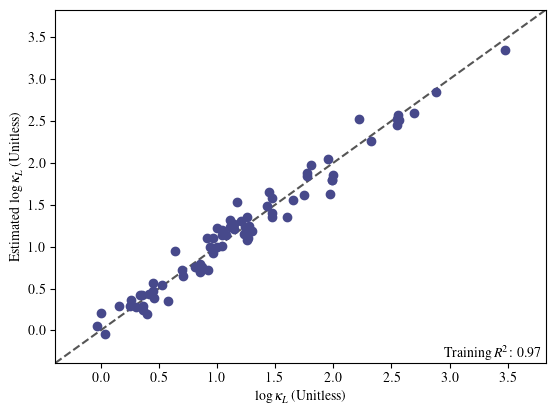

In [8]:
from sissopp.postprocess.plot.parity_plot import plot_model_parity_plot

fig = plot_model_parity_plot(model)

In [9]:
# Get the data to map out a model
f0_lims = [3e-6, 2e-5]
f1_lims = [1.0, 3.5]

xx, yy = np.meshgrid(
    np.linspace(f0_lims[0], f0_lims[1], 301),
    np.linspace(f1_lims[0], f1_lims[1], 301)
)
kap = model.coefs[0][-1] + model.coefs[0][0] * xx + model.coefs[0][1] * yy

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


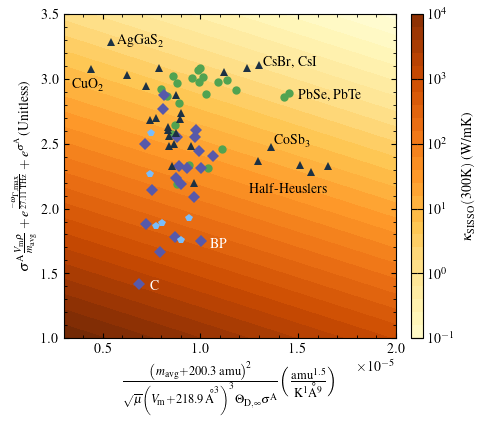

In [10]:
# Setup the figure
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[5.0303030303, 4.32])
ax.tick_params(direction="in", which="both", right=True, top=True)
fig.subplots_adjust(top=0.95, bottom=0.2, left=0.14, right=0.8)

# Setup axes based on the feature models
ax.set_xlabel(
    "$\\frac{ \\left(m_\\mathrm{avg}+200.3\\, \\mathrm{amu}\\right)^2}{ \\sqrt{ \\mu }\\left(V_\\mathrm{m}+218.9 \\,\\mathrm{\\AA}^3\\right)^3  \\Theta_\\mathrm{D, \\infty} \\sigma^\\mathrm{A}} \\mathrm{\\left(\\frac{amu^{1.5}}{K^{1}\\AA^{9}}\\right)}$",
    fontsize=12,
)
ax.set_xlim(f0_lims)
ax.set_xticks(np.arange(5e-6, 2.1e-5, 5e-6))
ax.set_xticks(np.arange(3e-6, 2.1e-5, 1.0e-6), minor=True)
ax.set_ylabel(
    "$\\sigma^\\mathrm{A}\\frac{ V_\\mathrm{m} \\rho}{ m_\\mathrm{avg} } + e^{\\frac{-\\omega_{\\Gamma, \\mathrm{max}}}{27.11\\,\\mathrm{THz}}} + e^{ \\sigma^\\mathrm{A} }$(Unitless)"
)

ax.set_ylim(f1_lims)
ax.set_yticks(np.arange(1.0, 3.51, 0.5))
ax.set_yticks(np.arange(1.0, 3.51, 0.1), minor=True)

# Plot the contour plot
ax.contourf(xx, yy, kap, cmap="YlOrBr", levels=30, vmin=-1.5, vmax=4.5)

#Set the colorbar properties
cbaxes = fig.add_axes(
    [
        0.83,
        ax.get_position().bounds[1],
        0.025,
        ax.get_position().bounds[3],
    ]
)

cnt = plt.contourf(
    [[1, 1], [2, 2]],
    [[1, 2], [1, 2]],
    [[0, 4], [-1, 2]],
    cmap="YlOrBr",
    levels=30,
    vmin=-1.5,
    vmax=4.5,
)
cbar = plt.colorbar(cnt, cax=cbaxes)
cbar.set_ticks(list(range(-1, 5)))
cbar.set_ticklabels(
    [
        "10$^\\mathrm{-1}$",
        "10$^\\mathrm{0}$",
        "10$^\\mathrm{1}$",
        "10$^\\mathrm{2}$",
        "10$^\\mathrm{3}$",
        "10$^\\mathrm{4}$",
    ]
)
cbar.ax.tick_params(axis="y", direction="in", left=True, right=True, length=4.0)
cbar.set_label("$\\kappa_{\\mathrm{SISSO}}\\left(\\mathrm{300 K}\\right)$ (W/mK)")

# Add the materials to the plot
rs_inds = np.where([ind.split("_")[0] == "B1" for ind in model.sample_ids_train])
zb_inds = np.where([ind.split("_")[0] == "B3" for ind in model.sample_ids_train])
wz_inds = np.where([ind.split("_")[0] == "B4" for ind in model.sample_ids_train])
ot_inds = [ii for ii in range(75) if ii not in np.hstack((rs_inds, zb_inds, wz_inds))]

plot_mats(model, rs_inds, "o", "#51A351", 6.0, "RS", ax)
plot_mats(model, zb_inds, "D", "#5759AA", 6.0, "ZB", ax)
plot_mats(model, wz_inds, "p", "#79BDFC", 6.0, "WZ", ax)
plot_mats(model, ot_inds, "^", "#1C3144", 6.0, "Other", ax)

# Label some materials
ax.text(1.25e-5, 2.125, "Half-Heuslers", color="k", zorder=100)
ax.text(1.375e-5, 2.495, "CoSb$_3$", color="k", zorder=100)
ax.text(1.5e-5, 2.85, "PbSe, PbTe", color="k", zorder=100)
ax.text(0.575e-5, 3.275, "AgGaS$_2$", color="k", zorder=100)
ax.text(0.345e-5, 2.925, "CuO$_2$", color="k", zorder=100)
ax.text(1.32e-5, 3.1, "CsBr, CsI", color="k", zorder=100)
ax.text(0.74e-5, 1.375, "C", color="w", zorder=100)
ax.text(1.05e-5, 1.70, "BP", color="w", zorder=100)

fig.show()

This linear map showing how the training set is distributed across materials space illustrates that the feature shown on the y-axis is primarily responsible for determining the thermal conductivity of the materials, while the x-axis describes some of the outliers.
However, the highly non-linear nature of these features makes it difficult to determine which exact properties should be optimized.
To do this we will need to use senstivity analysis to pin point which features are actually the most important ones.

# Mapping Against the Primary Features

To determine which primary features are the most important in describing a materials thermal conductivity, we employ the Sobol indices, i.e., the first order sensitivity index $S_i$ and the total sensitivity index $S_i^{T}$, using an algorithm that includes correlative effects first described by Kucherenko {\em et al}., and later implemented in UQLab.
The main advantage of this approach is that it includes the multivariate distribution properties of the inputs, which if ignored can largely bias or even falsify the sensitivity analysis results.
Qualitatively, the first order sensitivity index $S_i$ quantifies how much the variance of $\log\left(\kappa_L \left(300\,\mathrm{K}\right)\right)$ correlates with the variance of a primary feature  $\hat{x}_i$,
and the total sensitivity index $S_i^{T}$ quantifies how much the variance of $\log\left(\kappa_L \left(300\,\mathrm{K}\right)\right)$ correlates with the primary feature  $\hat{x}_i$ including all interactions between $\hat{x}_i$ and the other primary features. 
In other words, Sobol indices of 1.0 indicate that the full range of $\log\left(\kappa_L \left(300\,\mathrm{K}\right)\right)$ values can be fully represented by changes in $\hat{x}_i$, whereas values of 0.0 indicate that $\log\left(\kappa_L \left(300\,\mathrm{K}\right)\right)$ is fully independent of $\hat{x}_i$.

Formally, these Sobol indices are defined as  
\begin{align}
    S_i     &=     \frac{\mathrm{Var}_{\hat{x}_i}               \left(E_{\widetilde{\mathcal{X}}_{i}}\left(\log\left(\kappa_L\left(300\,\mathrm{K}\right)\right) | \hat{x}_i                     \right) \right)}{\mathrm{Var}\left(\log\left(\kappa_L\left(300\,\mathrm{K}\right)\right)\right)} \\
    S_i^{T} &= 1 - \frac{\mathrm{Var}_{\widetilde{\mathcal{X}}_i}\left(E_{\hat{x}_i}                      \left(\log\left(\kappa_L\left(300\,\mathrm{K}\right)\right) | \widetilde{\mathcal{X}}_i\right) \right)}{\mathrm{Var}\left(\log\left(\kappa_L\left(300\,\mathrm{K}\right)\right)\right)} 
\end{align}
where $\hat{x}_i \in \hat{\mathcal{X}}$ is an one of the features in the primary feature set,  $\mathrm{Var}_{a}\left(B\right)$ is the variance of $B$ with respect to $a$, $E_a\left(B\right)$ is the mean of $B$ after sampling over $a$, and $\widetilde{\mathcal{X}}_i$ is the set of all variables excluding $\hat{x}_i$.
For the sampling, we use Guassian copulas, so to properly account for correlation between primary features.
As a note because we are calculating the Sobol indices in this manner, correlative effects will only be included within $S_i$, which implies that if $S^T_i < S_i$, then correlative effects are significant.

In [11]:
df_sobol = pd.read_csv("./data/kappa-sigma-sisso/sobol-bar/sobol.csv", delimiter=";")
for ind in df_sobol.index:
    df_sobol.loc[ind, "Row"] = "$" + latexify(df_sobol.loc[ind, "Row"]).replace("$", "") + "$"

df_sobol["used"] = False
df_sobol.loc[df_sobol.index[1:4], "used"] = True

In [12]:
%load_ext rpy2.ipython

In [13]:
df_inputs = strip_units(df)
df_inputs = df_inputs[['m_avg', '\\Theta_D_\\infty', "\\sigma", 'V_m', '\\mu', '\\rho', '\\omega_\\Gamma_max']]
df_r = df_inputs.rename(
    columns={
        "\\Theta_D_\\infty" : "Theta_D_infty", 
        "\\mu" : "mu",
        "\\rho": "rho", 
        "\\omega_\\Gamma_max":"omega_Gamma_max",
        "\\sigma": "sigma",
    }
)

In [14]:
%%R -i df_r -w 5 -h 5 --units in -r 200

library("shapr")
library(data.table)

kap_model <- setClass("kap_model", slots = c(x="data.frame"))

predict.kap_model <- function(obj, newdata)
{
  log_kap = 6.327291237902646 - 82186.09346149210 * ((((newdata$m_avg+200.2889)^2) / (newdata$Theta_D_infty * newdata$sigma)) / (((newdata$V_m+218.9189)^3) * sqrt(newdata[5]))) - 1.704174115988004 * (((newdata$rho * newdata$sigma) * (newdata$V_m / newdata$m_avg)) + ((exp(-1.0 * (0.03688195*newdata$omega_Gamma_max))) + exp(newdata$sigma)))
  
  colnames(log_kap)[1] <- "log_kap"
  return(log_kap$log_kap)
}

predict_model.kap_model <- function(obj, newdata)
{
  predict(obj, as.data.frame(newdata))
}

get_model_specs.kap_model <- function(obj)
{
  x_dt <- data.table::as.data.table(obj@x)
  feature_list <- get_data_specs(x_dt)
  feature_list$specs_type <- "data"
  return(feature_list)
}

shap_model <- kap_model(x=df_r)
explainer <- shapr(df_r, shap_model)
p0 = mean(predict(shap_model, df_r))

explanation_empirical <- explain(df_r, explainer, approach = "empirical", prediction_zero = p0)
explanation_copula <- explain(df_r, explainer, approach = "copula", prediction_zero = p0)

shap_m_avg <- c(mean(abs(explanation_empirical$dt$m_avg)), mean(abs(explanation_copula$dt$m_avg)))
shap_Theta_D_infty <- c(mean(abs(explanation_empirical$dt$Theta_D_infty)), mean(abs(explanation_copula$dt$Theta_D_infty)))
shap_sigma <- c(mean(abs(explanation_empirical$dt$sigma)), mean(abs(explanation_copula$dt$sigma)))
shap_V_m <- c(mean(abs(explanation_empirical$dt$V_m)), mean(abs(explanation_copula$dt$V_m)))
shap_mu <- c(mean(abs(explanation_empirical$dt$mu)), mean(abs(explanation_copula$dt$mu)))
shap_rho <- c(mean(abs(explanation_empirical$dt$rho)), mean(abs(explanation_copula$dt$rho)))
shap_omega_Gamma_max <- c(mean(abs(explanation_empirical$dt$omega_Gamma_max)), mean(abs(explanation_copula$dt$omega_Gamma_max)))

df_shap <- data.table("m_avg"=shap_m_avg, "Theta_D_infty" = shap_Theta_D_infty, "sigma" = shap_sigma, "V_m" = shap_V_m, "mu" = shap_mu, "rho" = shap_rho, "omega_Gamma_max" = shap_omega_Gamma_max)
rownames(df_shap)[1] <- "SHAP_Ker^emp"
rownames(df_shap)[2] <- "SHAP_Ker^copula"

df_shap_T <- as.data.table(transpose(df_shap))
colnames(df_shap_T) <- rownames(df_shap)
rownames(df_shap_T) <- colnames(df_shap)
df_shap <- df_shap_T


R[write to console]: data.table 1.14.6 using 2 threads (see ?getDTthreads).  Latest news: r-datatable.com



In [15]:
df_shap = robjects.globalenv['df_shap']

In [16]:
final_model = load_model("final_model.dat")

def get_shap(fact=1.0):
    predict = lambda df: fact * final_model.eval_many({col: df[col].values for col in df.columns})

    masker = Independent(df_inputs, max_samples=100000)
    explainer = Exact(predict, masker=masker)

    shap_values = explainer(df_inputs, interactions=1)
    mean_shap_1 = np.abs(shap_values.values).mean(axis=0)

    return mean_shap_1


def get_lime(fact=1.0):
    predict = lambda arr: fact * final_model.eval_many(
        {col: arr[:, cc] for cc, col in enumerate(df_inputs.columns)}
    )

    lime_explainer = lime.lime_tabular.LimeTabularExplainer(
        df_inputs.values, feature_names=df_inputs.columns, mode="regression"
    )
    lime_vals = []
    for ind in df_inputs.index:
        exp = lime_explainer.explain_instance(
            df_inputs.loc[ind, :], predict, num_features=len(df_inputs.columns)
        )
        exp_map = exp.as_map()[1]
        lime_vals.append(np.zeros(len(df_inputs.columns)))
        for comb in exp_map:
            lime_vals[-1][comb[0]] = np.abs(comb[1])

    mean_lime = np.array(lime_vals).mean(axis=0)

    return mean_lime

def get_sobol():
    fxn = final_model.eval_many
    problem = {
      'num_vars': len(df_inputs.columns),
      'names': list(df_inputs.columns),
      'bounds': [[df_inputs[col].values.min(), df_inputs[col].values.max()] for col in df_inputs.columns]
    }
    param_values = sample(problem, 2**15)
    Y = fxn({col: param_values[:, cc] for cc, col in enumerate(df_inputs.columns)})
    Si = analyze(problem, Y)
    return Si["S1"], Si["ST"]

In [17]:
shap_uncorr = get_shap()
LIME = get_lime()
s1_uncorr, sT_uncorr = get_sobol()

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


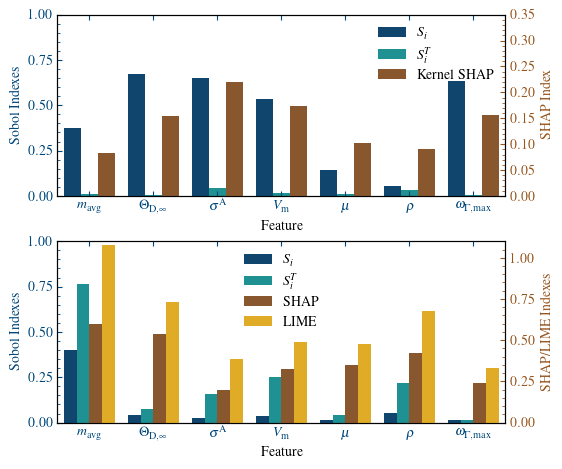

In [18]:
latex_names = {
    "m_avg": "$m_\\mathrm{avg}$",
    "\\Theta_D_\\infty": "$\\Theta_\\mathrm{D,\\infty}$",
    "\\sigma": "$\\sigma^\\mathrm{A}$",
    "V_m": "$V_\\mathrm{m}$",
    "\\mu": "$\\mu$",
    "\\rho": "$\\rho$",
    "\\omega_\\Gamma_max": "$\\omega_\\mathrm{\\Gamma, max}$",
}

def plot_sensitivity(df, ax):
    df = df.copy()
    df["Feature"] = [latex_names[feat] for feat in df["Feature"].values]

    sobol_df = df.copy()
    sobol_df.iloc[14:, 0] = 0.0

    shap_lime_df = df.copy()
    shap_lime_df.iloc[:14, 0] = 0.0

    twin_ax = ax.twinx()
    twin_ax.tick_params(
        colors="#98561F", direction="in", which="both", right=True, top=True
    )
    ax.tick_params(colors="#00487C", which="both")

    sns.barplot(
        data=sobol_df,
        x="Feature",
        y="Value",
        hue="Index",
        palette=["#00487C", "#0CA4A5", "#98561F", "#FFBA08"],
        ax=ax,
        # legend=False,
    )

    sns.barplot(
        data=shap_lime_df,
        x="Feature",
        y="Value",
        hue="Index",
        palette=["#00487C", "#0CA4A5", "#98561F", "#FFBA08"],
        ax=twin_ax,
        # legend=False,
    )
    ax.set_ylim([0.0, 1.00])
    ax.set_yticks(np.arange(0.0, 1.01, 0.25))
    ax.set_yticks(np.arange(0.0, 1.01, 0.05), minor=True)

    ax.set_ylabel("Sobol Indexes", color="#00487C")

    if len(df.index) == 21:
        twin_ax.set_ylabel("SHAP Index", color="#98561F")
        twin_ax.set_ylim([0.0, 0.35])
        twin_ax.set_yticks(np.arange(0.0, 0.36, 0.05))
        twin_ax.set_yticks(np.arange(0.0, 0.36, 0.01), minor=True)
    else:
        twin_ax.set_ylabel("SHAP/LIME Indexes", color="#98561F")
        twin_ax.set_ylim([0.0, 1.10])
        twin_ax.set_yticks(np.arange(0.0, 1.11, 0.25))
        twin_ax.set_yticks(np.arange(0.0, 1.11, 0.05), minor=True)

    ax.get_legend().remove()
    twin_ax.get_legend().set(frame_on=False)
    twin_ax.get_legend().set(title="")

data_corr = np.hstack((df_sobol.loc[:, ["S$_i$", "S$_i^T$"]].values.transpose().flatten(), np.array(df_shap[1]).flatten()))
data_uncorr = np.hstack((s1_uncorr, sT_uncorr, shap_uncorr, LIME))

df_corr = pd.DataFrame(data=data_corr, columns=["Value"])
df_corr["Index"] = np.repeat(["$S_i$", "$S_i^T$", "Kernel SHAP"], 7)
df_corr["Feature"] = list(df_inputs.columns) * 3

df_uncorr = pd.DataFrame(data=data_uncorr, columns=["Value"])
df_uncorr["Index"] = np.repeat(["$S_i$", "$S_i^T$", "SHAP", "LIME"], 7)
df_uncorr["Feature"] = list(df_inputs.columns) * 4

fig, axs = plt.subplots(nrows=2, ncols=1)
for ax in axs.flatten():
    ax.tick_params(direction="in", which="both", right=True, top=True)

fig.subplots_adjust(
    top=0.95, bottom=0.1, left=0.15, right=0.85, hspace=0.25, wspace=0.22
)

plot_sensitivity(df_corr, axs[0])
plot_sensitivity(df_uncorr, axs[1])
fig.show()

From these results we can see that the anharmonicity factor, $\sigma^\mathrm{A}$; the molar volume $V_\mathrm{m}$; and the high-temperature Debye Temperature $\Theta_\mathrm{D,\,\infty}$ are the most important variables for describing the thermal conductivity. While the maximum phonon frequency at the $\Gamma$-point $\omega_\mathrm{\Gamma,\, max}$ also has high Sobol indicies, these values are likely a result of correlation between $\omega_\mathrm{\Gamma,\, max}$ and $\Theta_\mathrm{D,\,\infty}$.

Using this knoweldge we can now map the expectation value of $\kappa_L\left(300\, \mathrm{K}\right)$ across these primary features.

In [19]:
plt.rcParams["font.size"] = 10

df_maps = strip_units(df)

def load_map(file):
    map_dat = np.loadtxt(file, delimiter=",")
    map_dat[np.where(map_dat[:, 4] < 10000)[0], 2] = np.nan
    return map_dat


def plot_1D_map(data, ax, x_lim, x_ticks, xm_ticks, x_label, yticklabels=False):
    ind = -1 * int(data[0, 1] < data[-1, 1])
    borders = [
        data[np.where((data[:, 1] - data[:, 2]) < 1.0)[0][ind], 0],
        data[np.where((data[:, 1]) < 1.0)[0][ind], 0],
        data[np.where((data[:, 1] + data[:, 2]) < 1.0)[0][ind], 0],
    ]
    print(sorted(borders))
    ax.tick_params(direction="in", which="both", right=True, top=True)
    ax.axvspan(
        borders[0], x_lim[ind == 0], color="#AAAAAA", alpha=0.25, lw=0, zorder=-5
    )
    ax.fill_between(
        data[:, 0],
        data[:, 1] - data[:, 2],
        data[:, 1] + data[:, 2],
        color="#F5E3E7",
        linewidth=0,
    )
    ax.plot(data[:, 0], data[:, 1], color="#a50026")
    ax.set_ylim([-1.0, 4.0])
    ax.set_yticks([-1, 0, 1, 2, 3, 4])
    if not yticklabels:
        ax.set_yticklabels([""] * 6)
    ax.set_yticks(np.log10(log_mticks), minor=True)

    ax.set_xlim(x_lim)
    ax.set_xticks(x_ticks)
    ax.set_xticks(xm_ticks, minor=True)
    ax.set_xlabel(x_label)


def plot_2D_map(
    data, ax, x_lim, x_ticks, xm_ticks, y_lim, y_ticks, ym_ticks, yticklabels=False
):
    ax.tick_params(direction="in", which="both", right=True, top=True)
    ax.contourf(
        data[:, 0].reshape((151, 151)),
        data[:, 1].reshape((151, 151)),
        data[:, 2].reshape((151, 151)),
        cmap="YlOrBr",
        levels=30,
        vmin=-1.5,
        vmax=4.5,
    )
    ax.set_xlim(x_lim)
    ax.set_xticks(x_ticks)
    ax.set_xticks(xm_ticks, minor=True)
    ax.set_xticklabels([""] * len(x_ticks))

    ax.set_ylim(y_lim)
    ax.set_yticks(y_ticks)
    ax.set_yticks(ym_ticks, minor=True)
    if not yticklabels:
        ax.set_yticklabels([""] * len(y_ticks))


def add_mats(ax, x_col, y_col):
    ax.plot(
        df_maps.loc[rs_inds, x_col],
        df_maps.loc[rs_inds, y_col],
        "o",
        color="#51A351",
        ms=3.0,
        markeredgewidth=0.0,
    )
    ax.plot(
        df_maps.loc[zb_inds, x_col],
        df_maps.loc[zb_inds, y_col],
        "D",
        color="#484FD5",
        ms=3.0,
        markeredgewidth=0.0,
    )
    ax.plot(
        df_maps.loc[wz_inds, x_col],
        df_maps.loc[wz_inds, y_col],
        "p",
        color="#79BDFC",
        ms=3.0,
        markeredgewidth=0.0,
    )
    ax.plot(
        df_maps.loc[ot_inds, x_col],
        df_maps.loc[ot_inds, y_col],
        "^",
        color="#1C3144",
        ms=3.0,
        markeredgewidth=0.0,
    )
    ax.plot(
        df_maps.loc[cl_inds, x_col],
        df_maps.loc[cl_inds, y_col],
        "^",
        color="#FEFEFE",
        ms=4.0,
        markeredgewidth=0.625,
        markeredgecolor="#000000",
    )

In [20]:
log_mticks = np.hstack(
    (
        np.arange(0.2, 1.0, 0.1),
        np.arange(2, 10, 1),
        np.arange(20, 100, 10),
        np.arange(200, 1000, 100),
        np.arange(2000, 10000, 1000),
    )
)

cl_inds = [
    "C1_b_SbCoTi",
    "C1_b_SnNiTi",
    "C1_b_VFeSb",
    "C1_b_ZrNiSn",
    "D0_2_CoSb3",
    "D5_1_Cr2O3",
    "E1_1_AgGaS2",
    "E1_1_CuGaTe2",
    "E1_1_ZnAs2Ge",
]

rs_inds = [ind for ind in df.index if ind.split("_")[0] == "B1"]
zb_inds = [ind for ind in df.index if ind.split("_")[0] == "B3"]
wz_inds = [ind for ind in df.index if ind.split("_")[0] == "B4"]
ot_inds = [
    ind for ind in df.index if ind not in (rs_inds + zb_inds + wz_inds + cl_inds)
]

map_s = load_map("./data/kappa-sigma-sisso/maps/sigma.csv")
map_t = load_map("./data/kappa-sigma-sisso/maps/theta_D.csv")
map_v = load_map("./data/kappa-sigma-sisso/maps/vm.csv")
map_tv = load_map("./data/kappa-sigma-sisso/maps/theta_vm.csv")
map_sv = load_map("./data/kappa-sigma-sisso/maps/sig_vm.csv")

map_s_ext = load_map("./data/kappa-sigma-sisso/maps/sigma_extended.csv")
map_t_ext = load_map("./data/kappa-sigma-sisso/maps/theta_D_extended.csv")
map_v_ext = load_map("./data/kappa-sigma-sisso/maps/vm_extended.csv")

[0.205960264900662, 0.280132450331126, 0.358940397350993]
[232.450331125828, 345.695364238411, 547.019867549669]
[35.7781456953642, 56.6390728476821, 83.4602649006623]


Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


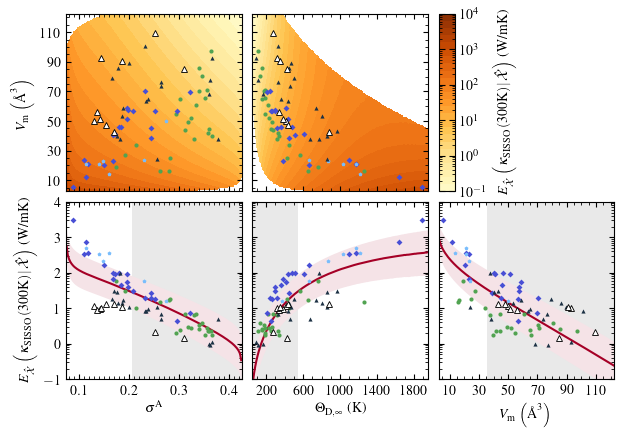

In [21]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=[6.45, 6.45 * 2.0 / 3.0])
fig.subplots_adjust(
    top=0.97, bottom=0.12, left=0.12, right=0.97, wspace=0.06, hspace=0.06
)

plot_1D_map(
    map_s,
    axs[1][0],
    [0.075, 0.425],
    np.arange(0.1, 0.41, 0.1),
    np.arange(0.08, 0.43, 0.01),
    "$\\sigma^\\mathrm{A}$",
    True,
)
axs[1][0].set_ylabel(
    "$E_{ \\mathscr{\\hat{X} } }\\left(\\left.\\kappa_{\\mathrm{SISSO}}\\left(\\mathrm{300 K}\\right) \\right| \\mathscr{\\hat{X} }\\right)$ (W/mK)"
)

plot_1D_map(
    map_t,
    axs[1][1],
    [50, 1950],
    list(range(200, 1801, 400)),
    np.arange(100, 1901, 100),
    "$\\Theta_\\mathrm{D,\\infty}$ (K)",
)
plot_1D_map(
    map_v,
    axs[1][2],
    [2.5, 122.5],
    range(10, 123, 20),
    range(5, 123, 5),
    "$V_\\mathrm{m}$ $\\left(\\mathrm{\\AA}^3\\right)$",
)
plot_2D_map(
    map_sv,
    axs[0][0],
    [0.075, 0.425],
    np.arange(0.1, 0.41, 0.1),
    np.arange(0.08, 0.43, 0.01),
    [2.5, 122.5],
    list(range(10, 123, 20)),
    list(range(5, 123, 5)),
    True,
)
axs[0][0].set_ylabel("$V_\\mathrm{m}$ $\\left(\\mathrm{\\AA}^3\\right)$")

plot_2D_map(
    map_tv,
    axs[0][1],
    [50, 1950],
    list(range(200, 1801, 400)),
    np.arange(100, 1901, 100),
    [2.5, 122.5],
    list(range(10, 123, 20)),
    list(range(5, 123, 5)),
)

cnt = plt.contourf(
    [[-10, -10], [-20, -20]],
    [[-10, -20], [-10, -20]],
    [[-1, 1], [4, 2]],
    cmap="YlOrBr",
    levels=30,
    vmin=-1.5,
    vmax=4.5,
)

cbaxes = fig.add_axes(
    [
        axs[0][2].get_position().bounds[0],
        axs[0][2].get_position().bounds[1],
        0.025,
        axs[0][2].get_position().bounds[3],
    ]
)
cbar = plt.colorbar(cnt, cax=cbaxes)
cbar.set_ticks(list(range(-1, 5)))
cbar.ax.yaxis.set_ticks(np.log10(log_mticks), minor=True)
cbar.set_ticklabels(
    [
        "10$^\\mathrm{-1}$",
        "10$^\\mathrm{0}$",
        "10$^\\mathrm{1}$",
        "10$^\\mathrm{2}$",
        "10$^\\mathrm{3}$",
        "10$^\\mathrm{4}$",
    ]
)
cbar.ax.tick_params(axis="y", direction="in", left=True, right=True, length=4.0)
cbar.ax.tick_params(which="minor", axis="y", direction="in", left=True, right=True)
cbar.set_label(
    "$E_{ \\mathscr{\\hat{X} } }\\left(\\left.\\kappa_{\\mathrm{SISSO}}\\left(\\mathrm{300 K}\\right) \\right| \\mathscr{\\hat{X} }\\right)$ (W/mK)"
)

fig.delaxes(axs[0][2])

add_mats(axs[0][0], "\\sigma", "V_m")
add_mats(axs[0][1], "\\Theta_D_\\infty", "V_m")
add_mats(axs[1][0], "\\sigma", "\\log \\kappa_L")
add_mats(axs[1][1], "\\Theta_D_\\infty", "\\log \\kappa_L")
add_mats(axs[1][2], "V_m", "\\log \\kappa_L")

fig.show()

# Kernel Ridge Regression (KRR)

In order to get an independent esitmate of the predicted thermal conductivity values we also generate a kernel-ridge regression model for the materials thermal conductivity. This test represents a sanity check for the prediction of the SISSO models because if models agree with each other then their predictions are more likely to be reliable.

In [22]:
df_krr = pd.read_csv("./data/kappa-sigma-sisso/full_dataset/data.csv", index_col=0)
prop = df_krr["\\log \\kappa_L"].values
df_krr.drop(columns = ["\\log \\kappa_L"], inplace=True)
feat_mean = df_krr.values.mean(axis=0)
feat_std = df_krr.values.std(axis=0)

krr_train = (df_krr.values - feat_mean) / feat_std
krr = KernelRidge(kernel="rbf", alpha=0.0017782794100389228, gamma=0.00794328234724282)
krr.fit(krr_train, prop)

KernelRidge(alpha=0.0017782794100389228, gamma=0.00794328234724282,
            kernel='rbf')

# Gaussian Process Regression (GPR)

In [23]:
df_gpr = pd.read_csv("./data/kappa-sigma-sisso/full_dataset/data.csv", index_col=0)
prop = df_gpr["\\log \\kappa_L"].values
df_gpr.drop(columns = ["\\log \\kappa_L"], inplace=True)
feat_mean = df_gpr.values.mean(axis=0)
feat_std = df_gpr.values.std(axis=0)

gpr_train = (df_gpr.values - feat_mean) / feat_std
kernel = RBF(length_scale=0.14125375446227553, length_scale_bounds=(1e-9, 1e2))
gpr = GaussianProcessRegressor(kernel=kernel, alpha=0.014125375446227554)
gpr.fit(gpr_train, prop)


GaussianProcessRegressor(alpha=0.014125375446227554,
                         kernel=RBF(length_scale=0.141))

# Parity Plots

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


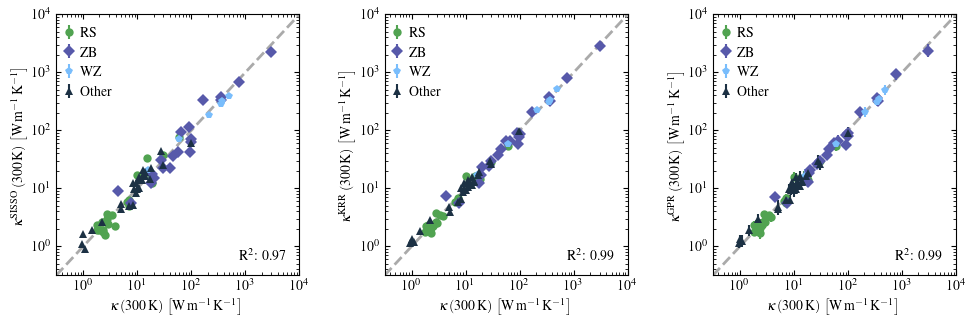

In [24]:
markers = ["o", "D", "p", "^"]
colors = ["#51A351", "#5759AA", "#79BDFC", "#1C3144"]
sizes = [3, 3, 3, 3]
labels = ["RS", "ZB", "WZ", "Other"]

# Get summary statistics
def get_afd(err):
    return 10 ** err.mean(axis=0)


def get_rmse(err):
    return np.sqrt(np.power(err, 2.0).mean(axis=0))


def get_r2(est, act):
    return np.corrcoef(est, act)[0, 1] ** 2.0



def plot_mats_parity(df, ax):
    x_key = "$\\kappa\\left(\\mathrm{300\\,K}\\right)$"
    y_key = df.columns[1]

    x_axis_label = x_key + " $\\left[\\mathrm{W\\,m^{-1}\\,K^{-1}}\\right]$"
    y_axis_label = y_key + " $\\left[\\mathrm{W\\,m^{-1}\\,K^{-1}}\\right]$"

    ax.set_xlabel(x_axis_label)
    ax.set_xticks(list(range(-1, 5)))
    ax.set_xticks(
        np.log10([aa * (10.0**bb) for bb in range(-1, 4) for aa in range(2, 10)]),
        minor=True,
    )
    ax.set_xticklabels([f"$10^{ {ii} }$" for ii in range(-1, 5)])
    ax.set_xlim([-0.5, 4.0])

    ax.set_ylabel(y_axis_label)
    ax.set_yticks(list(range(-1, 5)))
    ax.set_yticks(
        np.log10([aa * (10.0**bb) for bb in range(-1, 4) for aa in range(2, 10)]),
        minor=True,
    )
    ax.set_yticklabels([f"$10^{ {ii} }$" for ii in range(-1, 5)])
    ax.set_ylim([-0.5, 4.0])

    ax.plot([-0.5, 4.0], [-0.5, 4.0], "--", lw=2, color="#AAAAAA")

    for ind_set, marker, size, color, label in zip(
        inds, markers, sizes, colors, labels
    ):
        ax.errorbar(
            df.loc[ind_set, x_key].values,
            df.loc[ind_set, y_key].values,
            yerr=df.loc[ind_set, "std"].values,
            fmt=marker,
            color=color,
            ms=6,
            markeredgewidth=0.0,
            label=label,
            capsize=0.0,
        )

    ax.legend(handlelength=0.05, frameon=False, loc=2)

    err = np.abs(df[x_key] - df[y_key])

    r2 = np.round(get_r2(df[x_key].values, df[y_key].values), 2)

    ax.text(3.75, -0.25, "$\\mathrm{R}^2$: " + f"{r2:0.2f}", ha="right")

train_df = strip_units(df)

rs_inds = [ind for ind in df.index if "B1" in ind]
zb_inds = [ind for ind in df.index if "B3" in ind]
wz_inds = [ind for ind in df.index if "B4" in ind]
ot_inds = [ind for ind in df.index if ind not in rs_inds + zb_inds + wz_inds]
inds = [rs_inds, zb_inds, wz_inds, ot_inds]


fig, axs = plt.subplots(nrows=1, ncols=3, figsize=[10, 3])
for ax in axs.flatten():
    ax.tick_params(direction="in", which="both", right=True, top=True)

fig.subplots_adjust(
    top=0.97, bottom=0.1, left=0.07, right=0.97, wspace=0.35, hspace=0.25
)

std = np.zeros(len(df.index))
sisso_df = pd.DataFrame(
    index=df.index, 
    data=np.column_stack(
        (
            df["\\log \\kappa_L"].values, 
            final_model.eval_many({col: train_df[col].values for col in train_df.columns}),
            std,
        )
    ), 
    columns=[
        "$\\kappa\\left(\\mathrm{300\\,K}\\right)$", 
        "$\\kappa^\\mathrm{SISSO}\\left(\\mathrm{300\\,K}\\right)$",
        "std",
    ]
)
krr_df = pd.DataFrame(
    index=df.index, 
    data=np.column_stack(
        (
            df["\\log \\kappa_L"].values, 
            krr.predict(krr_train),
            std,
        )
    ), 
    columns=[
        "$\\kappa\\left(\\mathrm{300\\,K}\\right)$", 
        "$\\kappa^\\mathrm{KRR}\\left(\\mathrm{300\\,K}\\right)$",
        "std",
    ]
)

gpr_pred, std = gpr.predict(gpr_train, True)
gpr_df = pd.DataFrame(
    index=df.index, 
    data=np.column_stack(
        (
            df["\\log \\kappa_L"].values, 
            gpr.predict(gpr_train),
            std
        )
    ), 
    columns=[
        "$\\kappa\\left(\\mathrm{300\\,K}\\right)$", 
        "$\\kappa^\\mathrm{GPR}\\left(\\mathrm{300\\,K}\\right)$",
        "std",
    ]
)
plot_mats_parity(sisso_df, axs[0])
plot_mats_parity(krr_df, axs[1])
plot_mats_parity(gpr_df, axs[2])

fig.show()


# Plotting CV Error

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


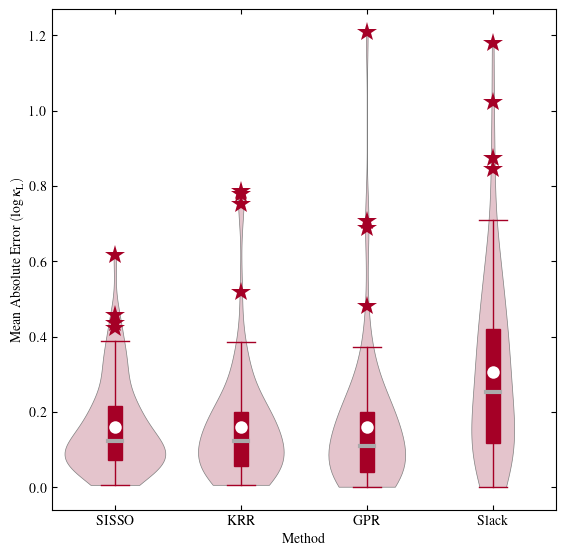

In [25]:
def get_data_dct(df):
    dct = {}
    for key in df.columns:
        dct[key] = df[key].to_numpy().astype(float)
    return dct

def get_test_error(direc, error_df):
    test_df = strip_units(f"{direc}/data_test.csv")
    cv_num = int(direc.split("/")[-2].split("_")[1]) // 10

    mean_val_rmse_1, var_val_rmse_1 = jackknife_cv_conv_est(f"{direc}/p_depth_1/cv*/")
    mean_val_rmse_3, var_val_rmse_3 = jackknife_cv_conv_est(f"{direc}/p_depth_3/cv*/")

    if mean_val_rmse_1[:-1].min() < mean_val_rmse_3[:-1].min():
        dim = mean_val_rmse_1.argmin() + 1
        comp_1_2 = mean_val_rmse_1[:-1].argmin() + 1
        depth = 1
    else:
        dim = mean_val_rmse_3.argmin() + 1
        comp_1_2 = mean_val_rmse_3[:-1].argmin() + 1
        depth = 3

    dim = dim if comp_1_2 == 2 else comp_1_2
    model = load_model(
        f"{direc}/p_depth_{depth}/train/models/train_dim_{dim}_model_0.dat"
    )
    model.to_file(f"{direc}/selected_model.dat", True)

    data_dct = get_data_dct(test_df)
    prop_est = model.eval_many(data_dct)
    error_df.loc[test_df.index[:], f"sisso_cv_{cv_num}"] = np.abs(
        prop_est - test_df["\\log \\kappa_L"]
    )

    test_krr = pd.read_csv(f"{direc}/krr_test_err.csv", index_col=0)
    error_df.loc[test_krr.index[:], f"krr_cv_{cv_num}"] = test_krr[test_krr.columns[-1]]

    test_gpr = pd.read_csv(f"{direc}/gpr_test_err.csv", index_col=0)
    error_df.loc[test_krr.index[:], f"gpr_cv_{cv_num}"] = test_gpr[test_gpr.columns[-1]]


def generate_err_df(base_dir, output_filename=None):
    data_df = pd.read_csv(f"{base_dir}/data.csv", index_col=0)

    error_df = pd.DataFrame(
        index=data_df.index,
        columns=[
            "sisso_cv_0",
            "sisso_cv_1",
            "sisso_cv_2",
            "krr_cv_0",
            "krr_cv_1",
            "krr_cv_2",
            "gpr_cv_0",
            "gpr_cv_1",
            "gpr_cv_2",
        ],
        data=np.zeros((len(data_df.index), 9)),
    )
    for direc in glob(f"{base_dir}/cv*/"):
        get_test_error(direc, error_df)

    if output_filename is not None:
        error_df.to_csv(output_filename, index_label="SB_Material")

    return data_df, error_df

def plot_box(df, hue, color, marker, marker_sz, ax, palette=["#A50026", "#2F315D"]):
    sns.boxplot(
        data=df,
        x="type",
        y="mae",
        hue=hue,
        orient="v",
        palette=palette,
        boxprops={"zorder": 100, "linewidth": 0, "linewidth": 1.0, "edgecolor": color},
        whiskerprops={"zorder": 100, "color": color, "linewidth": 1.0},
        capprops={"zorder": 100, "color": color, "linewidth": 1.0},
        width=0.45,
        showmeans=True,
        whis=[0, 95],
        medianprops={"linewidth": 3.0, "color": "#AAAAAA", "zorder": 200},
        meanprops={
            "marker": "o",
            "markersize": 9.0,
            "markerfacecolor": "#FFFFFF",
            "markeredgewidth": 0.0,
            "zorder": 200,
        },
        flierprops={
            "marker": marker,
            "markersize": marker_sz,
            "markerfacecolor": color,
            "markeredgewidth": 0.0,
            "zorder": 200,
        },
        dodge=True,
        saturation=1.0,
        ax=ax,
        linewidth=1.0,
    )


def plot_violin(df, hue, ax, palette=["#E9BFC9", "#C2C2D8"]):
    sns.violinplot(
        data=df,
        x="type",
        y="mae",
        hue=hue,
        cut=0.0,
        inner=None,
        split=hue is not None,
        scale="area",
        palette=palette,
        ax=ax,
        linewidth=0.5,
    )

full_df, error_full_df = generate_err_df("data/kappa-sigma-sisso/full_dataset/", "error_full_df.csv")

log_kap = full_df["\\log \\kappa_L"].values
sisso_full_ae = error_full_df[["sisso_cv_0", "sisso_cv_1", "sisso_cv_2"]].values
krr_full_ae = error_full_df[["krr_cv_0", "krr_cv_1", "krr_cv_2"]].values
gpr_full_ae = error_full_df[["gpr_cv_0", "gpr_cv_1", "gpr_cv_2"]].values

# Generate the data structures for the Slack Model
slack_df = pd.read_csv("data/kappa-sigma-sisso/slack.csv", index_col=0)
slack_df["cubic"] = True
for index in slack_df.index:
    if "_".join(index.split("_")[:-1]) not in ["B1", "B3", "C1", "C1_b", "D0_2"]:
        slack_df.loc[index, "cubic"] = False

slack_ae = np.abs(
    np.log10(slack_df["\\kappa_exp"].values)
    - np.log10(slack_df["\\kappa_Slack"].values)
)

# Setup plotting data-frames
typ = np.hstack(
    (
        ["SISSO"] * len(sisso_full_ae),
        ["KRR"] * len(krr_full_ae),
        ["GPR"] * len(krr_full_ae),
        ["Slack"] * len(slack_ae),
    )
)
mae = np.hstack(
    (
        np.mean(sisso_full_ae, axis=1),
        np.mean(krr_full_ae, axis=1),
        np.mean(gpr_full_ae, axis=1),
        slack_ae.flatten(),
    )
)

cv_err_df = pd.DataFrame(
    data=np.column_stack((typ, mae)), columns=["type", "mae"]
)
cv_err_df["mae"] = pd.to_numeric(cv_err_df["mae"])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=[6.5, 6.5])
ax.tick_params(direction="in", which="both", right=True, top=True)

plot_violin(cv_err_df, None, ax, ["#E9BFC9"])
plot_box(cv_err_df, None, "#A50026", "*", 15, ax, ["#A50026"])
adjust_box_widths(ax, 0.25)
ax.set_xlabel("Method")
ax.set_ylabel("Mean Absolute Error $\\left(\\log \\kappa_\\mathrm{L}\\right)$")
fig.show()

# Parity Plots of the Predicted Data

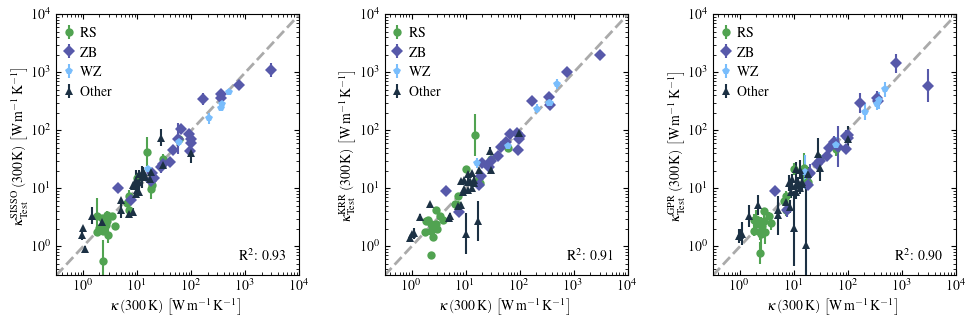

In [26]:
def get_data_dct(df):
    dct = {}
    stripped_df = strip_units(df)
    for key in stripped_df.columns:
        dct[key] = stripped_df[key].to_numpy().astype(float)
    return dct


def get_prediction(direc, pred_df):
    test_df = strip_units(f"{direc}/data_test.csv")
    cv_num = int(direc.split("/")[-2].split("_")[1]) // 10

    sisso_model = load_model(f"{direc}/selected_model.dat")

    data_dct = get_data_dct(test_df)
    pred_df.loc[test_df.index[:], f"sisso_cv_{cv_num}"] = sisso_model.eval_many(
        data_dct
    )

    test_krr = pd.read_csv(f"{direc}/krr_test_err.csv", index_col=0)
    pred_df.loc[test_krr.index[:], f"krr_cv_{cv_num}"] = test_krr[test_krr.columns[1]]

    test_gpr = pd.read_csv(f"{direc}/gpr_test_err.csv", index_col=0)
    pred_df.loc[test_krr.index[:], f"gpr_cv_{cv_num}"] = test_gpr[test_gpr.columns[1]]
    pred_df.loc[test_krr.index[:], f"gpr_std_cv_{cv_num}"] = test_gpr[
        test_gpr.columns[2]
    ]


def get_mean_std_df(data_df, df, key):
    pred_data = df[[f"{key}_cv_0", f"{key}_cv_1", f"{key}_cv_2"]].values
    data = np.column_stack(
        (
            data_df.loc[pred_df.index, "\\log \\kappa_L"].values,
            pred_data.mean(axis=1),
            pred_data.std(axis=1),
        )
    )

    if key == "gpr":
        pred_std_data = df[
            [f"{key}_std_cv_0", f"{key}_std_cv_1", f"{key}_std_cv_2"]
        ].values
        data[:, 2] = np.sqrt(np.sum(pred_std_data**2.0, axis=1) / 3.0)

    return pd.DataFrame(
        index=pred_df.index,
        data=data,
        columns=[
            "$\\kappa\\left(\\mathrm{300\\,K}\\right)$",
            "$\\kappa^\\mathrm{"
            + key.upper()
            + "}_\\mathrm{Test}\\left(\\mathrm{300\\,K}\\right)$",
            "std",
        ],
    )


def generate_pred_df(base_dir, output_filename=None):
    data_df = pd.read_csv(f"{base_dir}/data.csv", index_col=0)

    pred_df = pd.DataFrame(
        index=data_df.index,
        columns=[
            "sisso_cv_0",
            "sisso_cv_1",
            "sisso_cv_2",
            "krr_cv_0",
            "krr_cv_1",
            "krr_cv_2",
            "gpr_cv_0",
            "gpr_cv_1",
            "gpr_cv_2",
            "gpr_std_cv_0",
            "gpr_std_cv_1",
            "gpr_std_cv_2",
        ],
        data=np.zeros((len(data_df.index), 12)),
    )
    for direc in glob(f"{base_dir}/cv*/"):
        get_prediction(direc, pred_df)

    if output_filename is not None:
        pred_df.to_csv(output_filename, index_label="SB_Material")

    return data_df, pred_df

data_df, pred_df = generate_pred_df(
    "data/kappa-sigma-sisso/full_dataset/", "error_full_df.csv"
)
data_dct = get_data_dct(data_df)

sisso_pred_df = get_mean_std_df(data_df, pred_df, "sisso")
krr_pred_df = get_mean_std_df(data_df, pred_df, "krr")
gpr_pred_df = get_mean_std_df(data_df, pred_df, "gpr")

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=[10, 3])
for ax in axs.flatten():
    ax.tick_params(direction="in", which="both", right=True, top=True)

fig.subplots_adjust(
    top=0.97, bottom=0.1, left=0.07, right=0.97, wspace=0.35, hspace=0.25
)

plot_mats_parity(sisso_pred_df, axs[0])
plot_mats_parity(krr_pred_df, axs[1])
plot_mats_parity(gpr_pred_df, axs[2])

# Screening

Using the information gained from the sensitivity analysis, we are now able to design a hierarchical, efficient high-throughput screening protocol. 
We first evaluate those primary features that are most easy and cheap to compute, i.e. the structural parameters, so to iteratively reduce the amount of candidate materials in each step. 
As an example, we demonstrate this procedure by identifying new thermal insulators within a set of 732 materials, within those compounds available in the materials project that feature the same crystallographic prototype as the ones used for training.
However, no experimental thermal conductivities have been reported for these 732 materials so far as we know. 
Using the one-dimensional maps in Figure \ref{fig:maps}c-e, we define new tests for thermal insulators based on the region where a $\kappa_L\left(300\,\mathrm{K}\right) \leq 10$ W/mK is within one standard deviation of the expected value for each of the highlighted primary features. 
We then recursively narrow down the pool of candidate materials by evaluating one primary feature after the other, starting from the simplest one, i.e., $V_\mathrm{m}$, which only requires a structural relaxation. 
By sorting out all materials with $V_\mathrm{m}< 35.5$ \AA (58 materials) and all (almost) metallic materials (DFT band gap $<0.2$ eV), we are left  with 304 candidate compounds. 
Only for these remaining systems we calculate a converged harmonic model using phonopy and evaluate the Debye temperature $\Theta_\mathrm{D,\,\infty}$. 
In this second step, we now remove all materials with $\Theta_\mathrm{D,\,\infty} > 547$ K as well as those where the harmonic model is not reliable, e.g. if the material is thermondynamically unstable, and are left with 159~candidates. 
Eventually, we compute $\sigma^\mathrm{A}$ for the remaining 159 materials and exclude all materials with a $\sigma^\mathrm{A} < 0.206$ (36 materials) or $\sigma^\mathrm{A} > 0.4$ (29 materials)\footnote{We exclude these materials because it was previously demonstrated that at this point $\sigma^\mathrm{A}$ can be qualitatively wrong}.
For the remaining 94 materials, we evaluate $\kappa_\mathrm{est}$ using the full SISSO equation given by the model. 
Of the 94 materials that passed all checks, 80 have a thermal conductivity below 10 W/mK, illustrating the success of this method. 
On average, the estimated value of $\log\left(\kappa_L\left(300\,\mathrm{K}\right)\right)$ is $0.605 \pm 0.436$ (4.02 W/mK) compared with $1.200 \pm 0.743$ (15.9 W/mK) for the training set.
More importantly this selected set has a significantly reduced range of thermal conductivities with a min and max of 0.135 W/mK 51.71 W/mK, respectively, compared with 0.94 W/mK and $3\,000$ W/mK for the training set.
This shows that the proposed strategy based on sensitivity analysis is indeed fully consistent with the developed SISSO model, hence allowing a rapid screening through material space.

In [27]:
def eval_model(df, model, phi_0):
    df_stripped = strip_units(df)
    data_dct = {col: df_stripped[col].values.astype(float) for col in df_stripped.columns}
    
    return final_model.eval_many(data_dct)

df_predict = strip_units("./data/kappa-sigma-sisso/screening/data_predict.csv")

krr_predict = krr.predict((df_predict.values - feat_mean) / feat_std)
sisso_predict = eval_model(df_predict, model, phi_0)

In [28]:
df_estimate = pd.DataFrame(
    index = df_predict.index,
    data = np.column_stack(
        (
            10.0**sisso_predict, 
            10.0**krr_predict,
        )
    ),
    columns=[
        "$\\kappa_{\\mathrm{SISSO}}\\left(\\mathrm{300\\,K}\\right)$", 
        "$\\kappa_{\\mathrm{KRR}}\\left(\\mathrm{300\\,K}\\right)$",
    ]
)
inds_sig_high = df_estimate.index[np.where(df_predict["\\sigma"] > 0.4)[0]]
df_estimate.drop(index=inds_sig_high, inplace=True)
df_predict.drop(index=inds_sig_high, inplace=True)

In [29]:
def get_cond(map_1d, factor, ind=0):
    if np.min(map_1d[:, 1] + factor * map_1d[:, 2]) > 1:
        return (-1)**ind * np.infty
    
    return map_1d[
        np.where(
            (map_1d[:, 1] + factor * map_1d[:, 2]) <= 1
        )[0][ind], 
        0
    ]

def set_failed_conditions(s_std_factor=-1.0, t_std_factor=-1.0, v_std_factor=-1.0):
    cond_v = get_cond(map_v_ext, v_std_factor, 0)
    inds_v = df_predict.index[
        np.where(df_predict["V_m"] < cond_v)[0].tolist()
    ]
    
    cond_t = get_cond(map_t_ext, t_std_factor, -1)
    inds_t = df_predict.index[
        np.where(df_predict["\\Theta_D_\\infty"] > cond_t)[0].tolist()
    ]
    
    cond_s = get_cond(map_s_ext, s_std_factor, 0)
    inds_s = df_predict.index[
        np.where(df_predict["\\sigma"] < cond_s)[0].tolist()
    ]
    
    df_estimate.loc[:, "Failed Condition"] = "None"
    df_estimate.loc[inds_s, "Failed Condition"] = "$\\sigma^\\mathrm{A}$"
    df_estimate.loc[inds_t, "Failed Condition"] = "$\\Theta_\\mathrm{D,\\infty}$"
    df_estimate.loc[inds_v, "Failed Condition"] = "$V_\\mathrm{m}$"

In [30]:
font = {
    'size': 16
}

sns.set_palette(
    [
        "#306B34",
        "#D19C1D",
        "#6594B8",
        "#592E83",
    ]
)

matplotlib.rc('font', **font)


def create_histogram(s_std_factor=-1, t_std_factor=-1, v_std_factor=-1):
    set_failed_conditions(s_std_factor, t_std_factor, v_std_factor)
    minor_ticks = np.hstack(
        (
            np.arange(0.04, 0.1, 0.01),
            np.arange(0.2, 1.0, 0.1),
            np.arange(2, 10, 1),
            np.arange(20, 100, 10),
            np.arange(200, 1000, 100),
            np.arange(2000, 10 ** 3.5, 1000),
        )
    )

    fig = plt.figure(figsize=[6.11, 6.11 * 1.25])

    ax1 = fig.add_axes([0.175, 0.14, 0.60, 0.48])
    ax2 = fig.add_axes([0.175, 0.64, 0.60, 0.12])
    ax3 = fig.add_axes([0.800, 0.14, 0.15, 0.48])

    ax1.tick_params(direction="in", which="both", right=True, top=True)
    ax1.tick_params(which="minor", width=0.75)

    ax1.set_yscale("log")
    ax1.set_xscale("log")
    sns.scatterplot(
        data=df_estimate,
        x="$\\kappa_{\\mathrm{SISSO}}\\left(\\mathrm{300\\,K}\\right)$",
        y="$\\kappa_{\\mathrm{KRR}}\\left(\\mathrm{300\\,K}\\right)$",
        hue="Failed Condition",
        ax=ax1,
        alpha=0.625,
        s=20.0,
        edgecolor="none",
        hue_order=[
            "$V_\\mathrm{m}$",
            "$\\Theta_\\mathrm{D,\\infty}$",
            "$\\sigma^\\mathrm{A}$",
            "None",
        ]
    )

    ax1.axhline(
        y=10.0,
        xmin=0.0,
        xmax=1.0,
        dashes=(4, 2),
        linewidth=1.0,
        color="#888888",
        zorder=-10,
    )
    ax1.axvline(
        x=10.0,
        ymin=0.0,
        ymax=1.0,
        dashes=(4, 2),
        linewidth=1.0,
        color="#888888",
        zorder=-10,
    )

    ax1.plot(
        [0.035, 10 ** 3.5],
        [0.035, 10 ** 3.5],
        "--",
        linewidth=1.0,
        color="#888888",
        zorder=-10,
    )
    ax1.set_xlim([0.035, 10 ** 3.5])
    ax1.set_ylim([0.035, 10 ** 3.5])

    ax1.set_xticks([0.1, 1.0, 10.0, 100.0, 1000.0])
    ax1.set_xticks(minor_ticks, minor=True)

    ax1.set_yticks([0.1, 1.0, 10.0, 100.0, 1000.0])
    ax1.set_yticks(minor_ticks, minor=True)

    ax1.legend(frameon=False, handlelength=0.5)

    model_std = 0.26909382478373356
    conf_int_95 = model_std * 1.96
    y_min = np.log10(0.035)
    ax1.fill_between(
        [0.035, 10 ** 3.5],
        [10 ** (y_min - conf_int_95), 10 ** (3.5 - conf_int_95)],
        [10 ** (y_min + conf_int_95), 10 ** (3.5 + conf_int_95)],
        color="#EEEEEE",
        linewidth=0.0,
        zorder=-20,
    )

    sns.histplot(
        data=df_estimate,
        x="$\\kappa_{\\mathrm{SISSO}}\\left(\\mathrm{300\\,K}\\right)$",
        hue="Failed Condition",
        stat="count",
        bins=33,
        binrange=[-2.0, 3.5],
        log_scale=[True, False],
        linewidth=0,
        alpha=1,
        legend=False,
        multiple="stack",
        hue_order=[
            "$V_\\mathrm{m}$",
            "$\\Theta_\\mathrm{D,\\infty}$",
            "$\\sigma^\\mathrm{A}$",
            "None",
        ],
        ax=ax2,
    )

    ax2.tick_params(direction="in", which="both", right=True, top=True, bottom=True)
    ax2.tick_params(which="minor", width=0.75)

    ax2.set_xticks([0.1, 1.0, 10.0, 100.0, 1000.0])
    ax2.set_xticks(minor_ticks, minor=True)
    ax2.set_xticklabels(["", "", "", "", ""])

    ax2.set_yticks([0, 20, 40])
    ax2.set_yticks([10, 30], minor=True)
    ax2.set_yticklabels(["0", "20", "40"])

    ax2.set_xlim([0.035, 10 ** 3.5])
    ax2.set_ylim([0.0, 40])
    ax2.set_xlabel("")
    ax2.set_ylabel("")

    sns.histplot(
        data=df_estimate,
        y="$\\kappa_{\\mathrm{KRR}}\\left(\\mathrm{300\\,K}\\right)$",
        hue="Failed Condition",
        stat="count",
        bins=33,
        binrange=[-2.0, 3.5],
        log_scale=[False, True],
        linewidth=0,
        alpha=1,
        legend=False,
        multiple="stack",
        hue_order=[
            "$V_\\mathrm{m}$",
            "$\\Theta_\\mathrm{D,\\infty}$",
            "$\\sigma^\\mathrm{A}$",
            "None",
        ],
        ax=ax3,
    )

    ax3.tick_params(direction="in", which="both", left=True, right=True, top=True)
    ax3.tick_params(which="minor", width=0.75)

    ax3.set_xticks([0, 20, 40])
    ax3.set_xticks([10, 30], minor=True)
    ax3.set_xticklabels(["0", "20", "40"])

    ax3.set_yticks([0.1, 1.0, 10.0, 100.0, 1000.0])
    ax3.set_yticks(minor_ticks, minor=True)
    ax3.set_yticklabels(["", "", "", "", ""])

    ax3.set_xlim([0.0, 40])
    ax3.set_ylim([0.035, 10 ** 3.5])

    ax3.set_xlabel("")
    ax3.set_ylabel("")


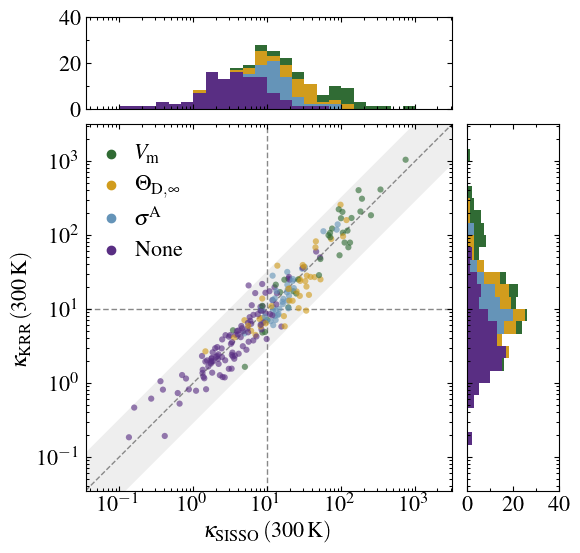

In [31]:
fig_paper = create_histogram()

Below you will find a tool to show how changing the one standard deviaion threhold impacts the screening of the materials.

In [32]:
colors = {
    "$V_\\mathrm{m}$": "#306B34",
    "$\\Theta_\\mathrm{D,\\infty}$": "#D19C1D",
    "$\\sigma^\\mathrm{A}$": "#6594B8",
    "None": "#592E83",
}

df_estimate["V<sub>m</sub>"] = df_predict["V_m"]
df_estimate["\u03B8<sub>D,\u221E</sub>"] = df_predict["\\Theta_D_\\infty"]
df_estimate["\u03C3<sup>A</sup>"] = df_predict["\\sigma"]
df_estimate["\u03BA<sub>SISSO</sub>"] = df_estimate["$\\kappa_{\\mathrm{SISSO}}\\left(\\mathrm{300\\,K}\\right)$"]
df_estimate["\u03BA<sub>KRR</sub>"] = df_estimate["$\\kappa_{\\mathrm{KRR}}\\left(\\mathrm{300\\,K}\\right)$"]

def get_scatter(s_std_factor=-1.0, t_std_factor=-1.0, v_std_factor=-1.0):
    set_failed_conditions(s_std_factor, t_std_factor, v_std_factor)
    fig = px.scatter(
        df_estimate,
        x="$\\kappa_{\\mathrm{SISSO}}\\left(\\mathrm{300\\,K}\\right)$",
        y="$\\kappa_{\\mathrm{KRR}}\\left(\\mathrm{300\\,K}\\right)$",
        color="Failed Condition",
        log_x=[0.035, 10 ** 3.5],
        log_y=[0.035, 10 ** 3.5],
        hover_name=df_estimate.index,
        hover_data={
            "$\\kappa_{\\mathrm{SISSO}}\\left(\\mathrm{300\\,K}\\right)$": False,
            "$\\kappa_{\\mathrm{KRR}}\\left(\\mathrm{300\\,K}\\right)$": False,
            "Failed Condition": False,
            "V<sub>m</sub>": ':.2f',
            "\u03B8<sub>D,\u221E</sub>":  ":.2f",
            "\u03C3<sup>A</sup>": ":.2f",
            "\u03BA<sub>SISSO</sub>": ":.2f",
            "\u03BA<sub>KRR</sub>": ":.2f",
        },
        color_discrete_map=colors,
        opacity=0.625,
        marginal_x="rug",
        marginal_y="rug",
        category_orders={
            "Failed Condition": [
                "$V_\\mathrm{m}$",
                "$\\Theta_\\mathrm{D,\\infty}$",
                "$\\sigma^\\mathrm{A}$",
                "None",
            ]
        }
    )
    return fig

figure = go.FigureWidget(get_scatter())

@interact(sig=(-3.5, 3.5, 0.1), theta=(-3.5, 3.5, 0.1), vm=(-3.5, 3.5, 0.1))
def update(sig=-1.0, theta=-1.0, vm=-1.0):
    updated_figure = get_scatter(sig, theta, vm)
    with figure.batch_update():
        figure.data = []
        for dat in updated_figure.data:
            figure.add_trace(dat)
figure

interactive(children=(FloatSlider(value=-1.0, description='sig', max=3.5, min=-3.5), FloatSlider(value=-1.0, d…

FigureWidget({
    'data': [{'customdata': array([['$V_\\mathrm{m}$', 16.6675612963896, 960.11034001885,
                                    0.161488518856246, 131.4185911947541, 78.97025198770513],
                                   ['$V_\\mathrm{m}$', 11.906720421248, 942.168611343505,
                                    0.397054564830112, 4.977305373345058, 1.65201994761098],
                                   ['$V_\\mathrm{m}$', 25.9301076513315, 458.037966701504,
                                    0.305404211505599, 8.59419995935867, 4.8019630934271404],
                                   ...,
                                   ['$V_\\mathrm{m}$', 31.7532510814745, 801.911449293705,
                                    0.166027346952075, 17.01989434867415, 24.873624908003833],
                                   ['$V_\\mathrm{m}$', 35.6347447343067, 717.082570086696,
                                    0.2178302040212, 8.554703840067203, 11.031664036665312],
                       